In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [2]:
api = KaggleApi()

In [3]:
api.authenticate()

In [5]:
api.competition_download_file('sentiment-analysis-on-movie-reviews', 'test.tsv.zip', path='./')
api.competition_download_file('sentiment-analysis-on-movie-reviews', 'train.tsv.zip', path='./')

100%|███████████████████████████████████████████████████████████████████████████████| 494k/494k [00:01<00:00, 461kB/s]


100%|█████████████████████████████████████████████████████████████████████████████| 1.28M/1.28M [00:02<00:00, 454kB/s]

In [6]:
import zipfile

with zipfile.ZipFile('./train.tsv.zip', 'r') as zf:
    zf.extractall()
    
with zipfile.ZipFile('./test.tsv.zip', 'r') as zf:
    zf.extractall()

In [8]:
import pandas as pd

df = pd.read_csv('train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [9]:
df.drop_duplicates(subset=['SentenceId'], keep='first')

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1
...,...,...,...,...
155984,155985,8540,... either you 're willing to go with this cla...,2
155997,155998,8541,"Despite these annoyances , the capable Claybur...",2
156021,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1
156031,156032,8543,The movie 's downfall is to substitute plot fo...,1


<AxesSubplot: >

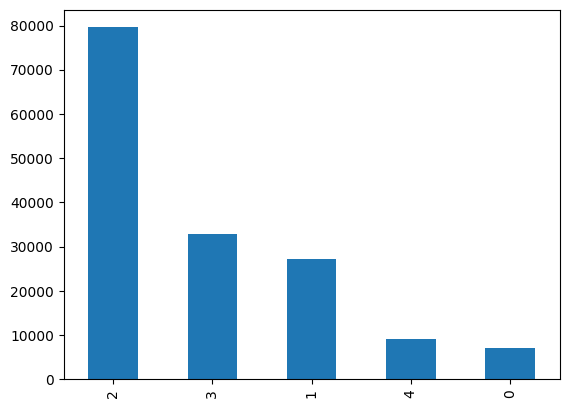

In [11]:
df['Sentiment'].value_counts().plot(kind='bar')

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [12]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(156060, 512)

In [14]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True, 
                   padding='max_length', add_special_tokens=True, return_tensors='np')

In [17]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [19]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [20]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [21]:
import numpy as np

with open('movie-xids.npy', 'wb') as mid:
    np.save(mid, tokens['input_ids'])
    
with open('movie-xmasks.npy', 'wb') as mask:
    np.save(mask, tokens['attention_mask'])

In [22]:
arr = df['Sentiment']
arr.shape

(156060,)

In [24]:
#one hot encoding

labels = np.zeros((num_samples, arr.max()+1))
labels[np.arange(num_samples), arr] = 1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [25]:
with open('movie-labels.npy', 'wb') as lbl:
    np.save(lbl, labels)